# Object Detection

Classification can tell you what object you are seeing but you may also need to answer
* Where is an object
* How many are there

We generally call this object detection

# Outline



* Our Goal for this lecture is to identify signs of Malaria in human blood smears




## Challenge Data Set

P. vivax (malaria) infected human blood smears

Accession number BBBC041 · Version 1



From the Broad Institute https://data.broadinstitute.org/bbbc/BBBC041/


<img src=https://data.broadinstitute.org/bbbc/BBBC041/BBBC041_example1.png>
    
Malaria is a disease caused by Plasmodium parasites that remains a major threat in global health, affecting 200 million people and causing 400,000 deaths a year. The main species of malaria that affect humans are Plasmodium falciparum and Plasmodium vivax.

For malaria as well as other microbial infections, manual inspection of thick and thin blood smears by trained microscopists remains the gold standard for parasite detection and stage determination because of its low reagent and instrument cost and high flexibility. Despite manual inspection being extremely low throughput and susceptible to human bias, automatic counting software remains largely unused because of the wide range of variations in brightfield microscopy images. However, a robust automatic counting and cell classification solution would provide enormous benefits due to faster and more accurate quantitative results without human variability; researchers and medical professionals could better characterize stage-specific drug targets and better quantify patient reactions to drugs.

Previous attempts to automate the process of identifying and quantifying malaria have not gained major traction partly due to difficulty of replication, comparison, and extension. Authors also rarely make their image sets available, which precludes replication of results and assessment of potential improvements. The lack of a standard set of images nor standard set of metrics used to report results has impeded the field. 



# Coordinates 

We are going to use the index coordinate system

<img src=../assets/index_coords.png>

* **Packages often have different systems so be careful!**
    

## Bounding Boxes

Data is often labeled by bounding boxes, which also can be describe in a number of different ways. We'll use 
Upper left corner (note this is the smallest y-coordinate), the length and the width. 

<img src=../assets/BBox.png>

Each bounding box also has a category attached to it. For example moon or cloud.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

import numpy as np

import matplotlib.pyplot as plt
from bbtoydata import BBToyData
import matplotlib.patches as patches
import tensorflow as tf



KeyboardInterrupt: 

In [ ]:
#Lets Practice

In [ ]:
x_pixel=0
y_pixel=1



img=np.zeros((3,3))

img[y_pixel,x_pixel]=1.0## Noice y,x here

fig,ax = plt.subplots(1)

ax.imshow(img,cmap='gray')

plt.xlabel(r" X -0.5 $\rightarrow$ 3.5 ")
plt.ylabel(r" 2.5 $\leftarrow$ -0.5  Y ")
print(img)


##Draw a bounding box
rec_corner=((x_pixel-0.5,y_pixel-0.5)) #half a pixel Width
width=1
height=1
# We'll uses pat
rec=patches.Rectangle(rec_corner, width,height,edgecolor='r',facecolor='none')
ax.add_patch(rec)
plt.show()

We'll add a lot of bounding boxes so let's write a function to do it

In [ ]:
def add_bbox(ax,bbox,color='r'):
    corner_x,corner_y,width,height=bbox
    rec=patches.Rectangle((corner_x-0.5,corner_y-0.5), width,height,edgecolor=color,facecolor='none')
    ax.add_patch(rec)

    

## Identifying where something is with a neural network

Again We'll use a toy example that's easy to under and visualize.
Start by finding just one object.

* 3-Object Classes 
    * Square
    * Circle
    * Triangle
* 1 - Background Class

* 4 - bbox x,y,width,height

We need a classification network to identify the shape, and a new network go predict the bounding box

* We'll use two prediction networks that share features!

<img src=../assets/network_diagrams/1_object_identifier.png>



In [ ]:
# Toy Data


In [ ]:
bb=BBToyData()

[[0, [9.16463740976103, 15.668403826066479, 26.454397849332167, 3.063784274662856]]]


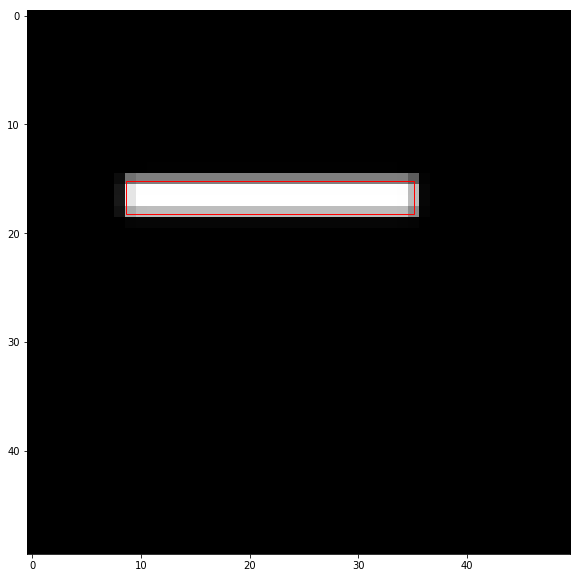

[[2, [6.242924583548555, 12.157509898107799, 31.12835044044199, 3.24276476773146]]]


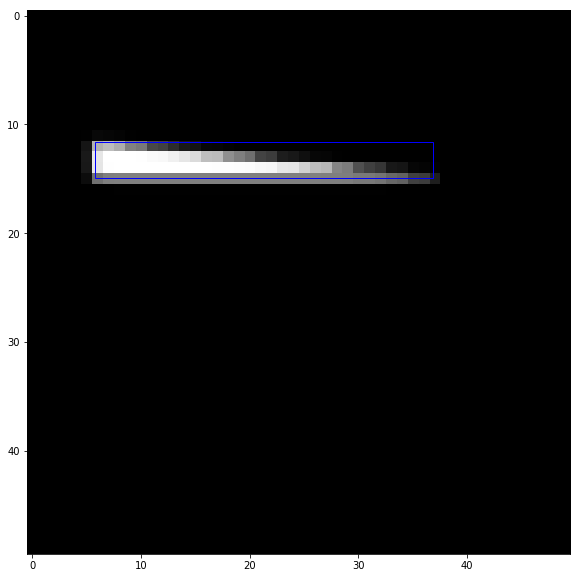

[[1, [22.736121321345838, 10.139542505801655, 16.238982107013378, 21.901847400390746]]]


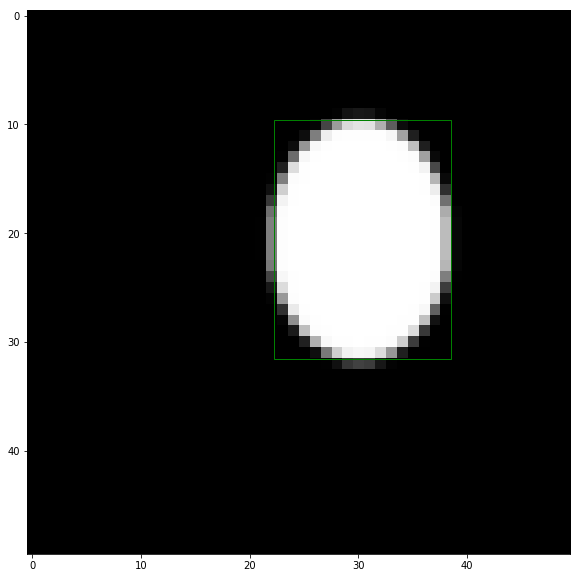

[[1, [16.561419765711154, 19.883967042822576, 27.91109245154409, 10.802397590869205]]]


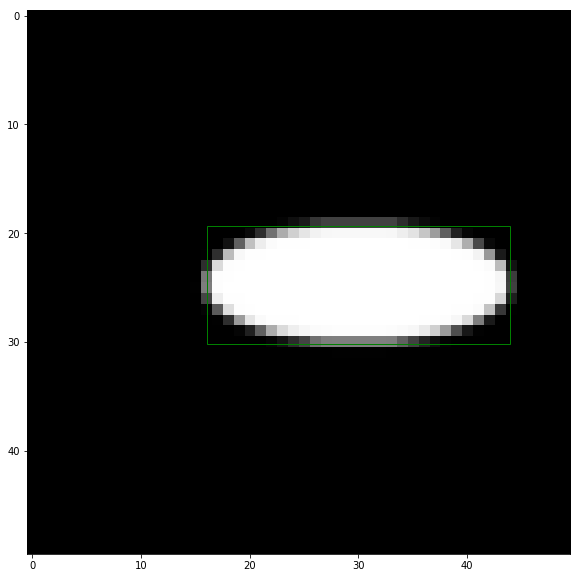

[[2, [16.279329445659034, 19.17731258064654, 17.297261736651844, 23.4928955598236]]]


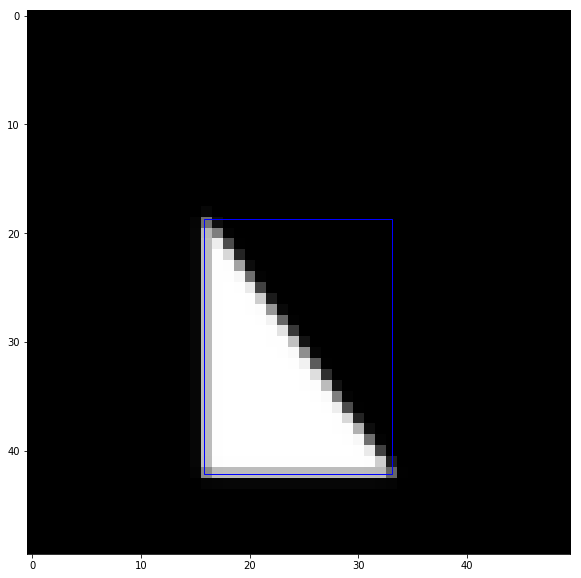

[[2, [14.039501903734056, 34.346041858761275, 25.700386284609444, 4.760041673053234]]]


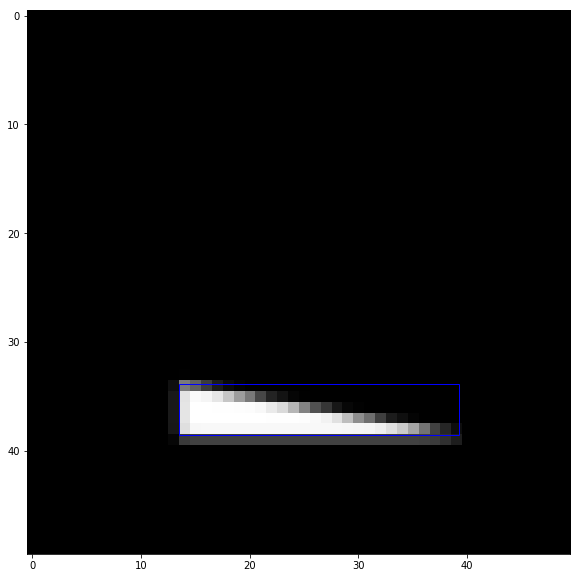

[]


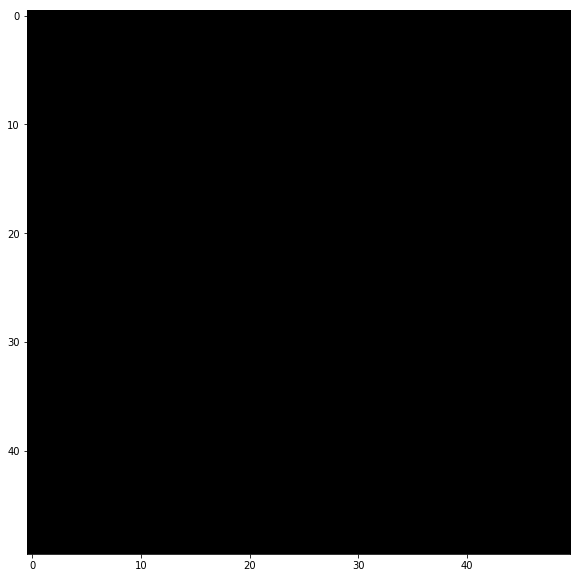

[]


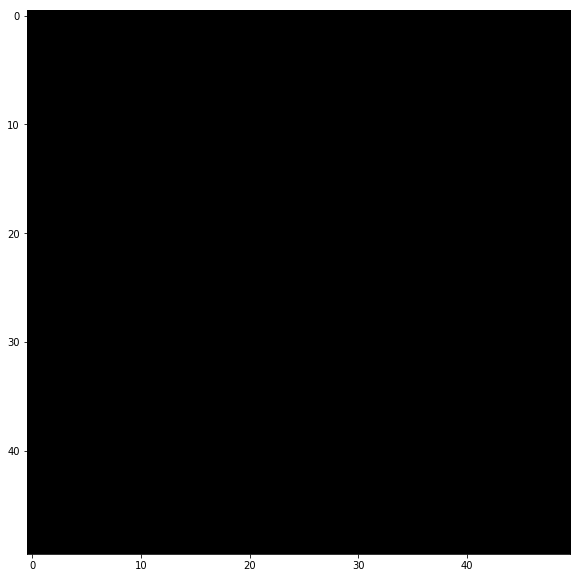

[[2, [8.86785797466947, 9.344827485804515, 13.139560281244078, 29.56518872912859]]]


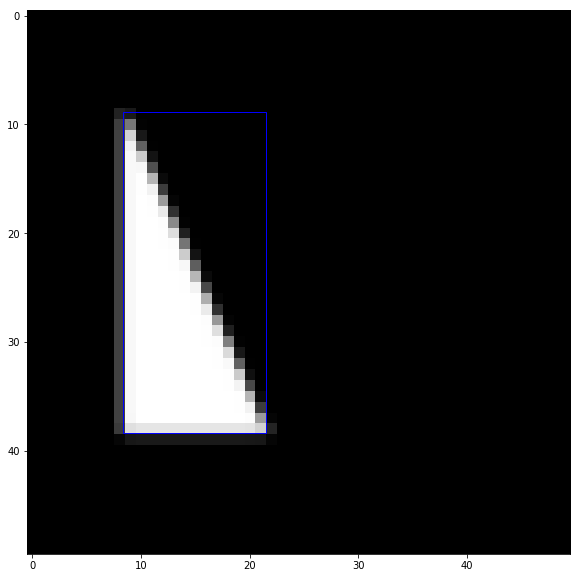

[[1, [8.408211677918832, 12.027210811599009, 27.20761786344678, 22.890637184477157]]]


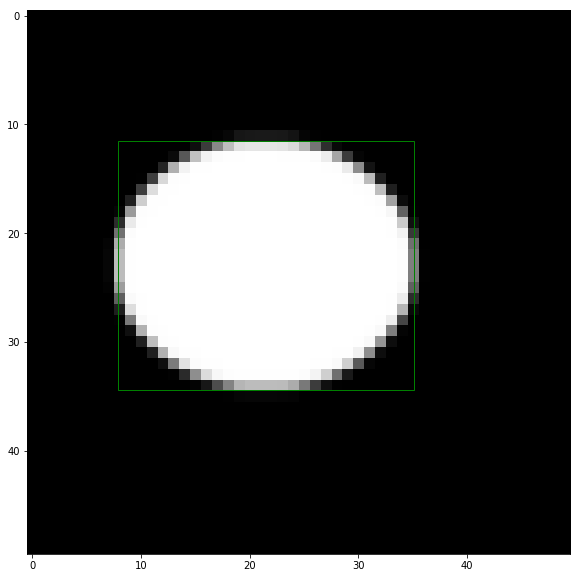

In [ ]:
plt.show()
def plot_example(image,labels):
    colors=['r','g','b','y','#000000']
    fig,ax = plt.subplots(1,figsize=(10,10))
    ax.imshow(image,cmap='gray')
    for cat,bbox in labels:
        add_bbox(ax,bbox,color=colors[cat])
    plt.show()
for i in range(10):
    index=np.random.randint(bb.X_train.shape[0])
    print(bb.Y_train[index])

    plot_example(np.squeeze(bb.X_train[index]),(bb.Y_train[index]))



In [ ]:
##Build our Convolutional Feature Finders

In [ ]:
cnn_input=tf.keras.layers.Input( shape=bb.X_train.shape[1:] ) # Shape here does not including the batch size 
cnn_layer1=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_input) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer1) 

cnn_layer2=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_activation) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer2) 

#cnn_layer3=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_activation) 
#cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer3) 

flat=tf.keras.layers.Flatten()(cnn_activation) 
flat=tf.keras.layers.Dropout(0.5)(flat)



In [ ]:
#Make Our Prediction layer
cat_output_layer=tf.keras.layers.Dense(4)(flat) 
cat_output=tf.keras.layers.Activation('softmax')(cat_output_layer)


#Make our bounding box regressor
bbox_output=tf.keras.layers.Dense(50)(flat) 
bbox_output=tf.keras.layers.LeakyReLU()(bbox_output)
bbox_output=tf.keras.layers.Dense(50)(bbox_output) 
bbox_output=tf.keras.layers.LeakyReLU()(bbox_output)
bbox_output=tf.keras.layers.Dense(4)(bbox_output) 







In [ ]:
model=tf.keras.models.Model(cnn_input,[cat_output,bbox_output])


##Two!! loss fuctions one for each output, the total loss is the sum of each of these
model.compile(loss=['categorical_crossentropy','mae'],
              optimizer='adam',
              metrics=[])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 1)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 25, 64)   1088        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 25, 25, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 13, 13, 64)   65600       leaky_re_lu[0][0]                
__________________________________________________________________________________________________
leaky_re_l

# Make our Data
We need to transform labels from a list to a one hot encoding


In [ ]:

def get_single_object_labels(labels):
    Y_bbox=[]
    Y_cat=[]
    for l in labels:
        if len(l)==0:
            Y_cat.append(3) #Background
            Y_bbox.append(np.array([[0,0,1,1]])) #Divide by our image size so everything is between 0-1
        else:
            cat,bbox=l[0]
            Y_cat.append(cat)
            Y_bbox.append(np.expand_dims(bbox,0)/50,) #Divide by our image size so everything is between 0-1
    Y_cat=tf.keras.utils.to_categorical(Y_cat, num_classes=4)
    Y_bbox=np.concatenate(Y_bbox)
    return [Y_cat,Y_bbox]

Y_train=get_single_object_labels(bb.Y_train)
Y_develop=get_single_object_labels(bb.Y_develop)
Y_test=get_single_object_labels(bb.Y_test)


In [ ]:

history=model.fit(bb.X_train, Y_train, 
          batch_size=32, epochs=25, verbose=1,
         validation_data=(bb.X_develop,Y_develop)
         )

Train on 18014 samples, validate on 79943 samples
Epoch 1/25
18014/18014 [==============================] - 16s 905us/step - loss: 0.4520 - activation_loss: 0.3860 - dense_3_loss: 0.0660 - val_loss: 0.1788 - val_activation_loss: 0.1358 - val_dense_3_loss: 0.0430
Epoch 2/25
18014/18014 [==============================] - 14s 758us/step - loss: 0.1498 - activation_loss: 0.1102 - dense_3_loss: 0.0396 - val_loss: 0.1083 - val_activation_loss: 0.0755 - val_dense_3_loss: 0.0328
Epoch 3/25
18014/18014 [==============================] - 14s 756us/step - loss: 0.1093 - activation_loss: 0.0729 - dense_3_loss: 0.0364 - val_loss: 0.0793 - val_activation_loss: 0.0511 - val_dense_3_loss: 0.0282
Epoch 4/25
18014/18014 [==============================] - 14s 754us/step - loss: 0.0978 - activation_loss: 0.0635 - dense_3_loss: 0.0343 - val_loss: 0.0598 - val_activation_loss: 0.0362 - val_dense_3_loss: 0.0236
Epoch 5/25
18014/18014 [==============================] - 14s 755us/step - loss: 0.0755 - activati

In [ ]:


cat_pred,bbox_pred=model.predict(bb.X_develop)






In [ ]:
for i in range(20):    
    cat=np.argmax(cat_pred[i])
    label=[ [cat,bbox_pred[i]*50]]
    plot_example(np.squeeze(bb.X_develop[i]),label)
    print(cat,bbox_pred[i]*100)
    print(bb.Y_develop[i])


## Identifying more than one thing at a time

**Run the next several cells to get your model training before we get started**


That worked pretty well, but we have another problem what if there is more than one object in the image. 
* There are several ways to handle this
    * Scan the image (like we did with the cancer example)
        * This works but can be expensive
    * Use multiple detectors
        * Strategry used by algorithms like SSD (single shot detector) or YOLO (you only look one)
        * Faster and better suited for devices
* Will discuss using multiple detectors
    * The algorithm above had 1 detector, and predicted one bounding box and one 
    * We can add more of them to detect several objects
* Challenges
    * How do we efficiently add detectors
    * How do we assign objects to detectors

* Convolutional Detectors
    * One way to add a lot of detectors quickly is to not use a dense layer at all
        * We replace the dense network above with two convolutional layers
        * Each layer will have 4 filters (so the output will have 4 channels)
            * We can apply a softmax to each pixel in one layer to get a category prediction
            * We can use the second layer for bounding box predictions
        
    

<img src=../assets/network_diagrams/multi_object_identifier.png>

In the case below our output CNN layers will have a shape of 5 pixels by 5 pixels,
so we we'll assign each of these pixels to watch a box in the original input image.
The area each pixel is watching for is called a prior box or an anchor. 

If the center of an object in in the box we assign it to that detector, otherwise a detector is assigned a background class.

<img src=../assets/network_diagrams/Detectors.png>

Another detail is instead of directly predicting the bounding box with make a prediction with respect to the prior box, we predict the x,y offsets to the new bounding box and the length and width scales.  

    
  


# Build It
Same problem now with the possiblity of multiple objects

In [ ]:
bb_multi=BBToyData(multi_object= True)

In [ ]:

plt.imshow(np.squeeze(bb_multi.X_train[10]))

In [ ]:

cnn_input=tf.keras.layers.Input( shape=bb_multi.X_train.shape[1:] ) # Shape here does not including the batch size 
cnn_layer1=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_input) #50x50
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer1) 
cnn_activation=tf.keras.layers.BatchNormalization()(cnn_activation) 

cnn_layer2=tf.keras.layers.Convolution2D(128, (4,4),strides=2,padding='same')(cnn_activation) #25x25
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer2) 
cnn_activation=tf.keras.layers.BatchNormalization()(cnn_activation) 

cnn_layer3=tf.keras.layers.Convolution2D(256, (10,10),strides=5,padding='same')(cnn_activation) #5x5
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer3) 
cnn_activation=tf.keras.layers.BatchNormalization()(cnn_activation) 
cnn_activation=tf.keras.layers.Dropout(.2)(cnn_activation) 


###Prediction Layers
prediction=tf.keras.layers.Convolution2D(4,(5,5),padding='same',activation='softmax')(cnn_activation)
#Softmax is applied to the last 
bbox_offset=tf.keras.layers.Convolution2D(4,(5,5),padding='same')(cnn_activation)


model=tf.keras.models.Model(cnn_input,[prediction,bbox_offset])

model.compile(loss=['categorical_crossentropy','mse'],
                  optimizer='adam',
                  metrics=[])
model.summary()

test,test1=model.predict(bb_multi.X_train[0:1])


In [ ]:


def get_labels(input_labels):
    Y_train=[[],[]]
    
    for image_labels in input_labels:
        class_features=np.zeros((5,5,4))
        class_features[:,:,3]=1. #Defaults to no class

        bbox_features=np.zeros((5,5,4))
        bbox_features[:,:,2:]=1. #Scale =1

        detected=[]
        
        
        for i,(cat,bbox) in enumerate(image_labels):
            bbox=[i/100. for i in bbox] # Normalize
            bbox_center_x=int((bbox[0]+bbox[2]/2.)//0.2) #priorbox bin
            bbox_center_y=int((bbox[1]+bbox[3]/2.)//0.2) #priorbox bin
            
            bbox_offset_x=(bbox[0]+bbox[2]/2.)/0.2-(bbox_center_x+0.5)#priorbox bin
            bbox_offset_y=(bbox[1]+bbox[3]/2.)/0.2-(bbox_center_y+0.5) #priorbox bin
            
            bbox_scale_x=bbox[2]/0.2
            bbox_scale_y=bbox[3]/0.2
            # Y comes first here
            class_features[bbox_center_y,bbox_center_x,cat]=25
            class_features[bbox_center_y,bbox_center_x,3]=0

            bbox_features[bbox_center_y,bbox_center_x,:]=[bbox_offset_x,bbox_offset_y,bbox_scale_x,bbox_scale_y]
        Y_train[0].append(np.expand_dims(class_features,0))
        Y_train[1].append(np.expand_dims(bbox_features,0))
    Y_train[0]=np.concatenate(Y_train[0])
    Y_train[1]=np.concatenate(Y_train[1])
    
    return Y_train
Y_train=get_labels(bb_multi.Y_train)
Y_develop=get_labels(bb_multi.Y_develop)
Y_test=get_labels(bb_multi.Y_test)







In [ ]:

#plt.imshow(np.argmax(Y_train[0][0],axis=-1))
bbox=Y_train[1][0]
plt.show()


for i in range(10):
    index=np.random.randint(len(bb_multi.X_train))
    plot_example(np.squeeze(bb_multi.X_train[index]),bb_multi.Y_train[index])

In [ ]:
history=model.fit(bb_multi.X_train, Y_train, 
        batch_size=32, epochs=25, verbose=1,
        validation_data=(bb_multi.X_develop,Y_develop)
                 )


In [ ]:

def predictions_to_labels(image,cat_map,bbox_map,show_background=False):
    # Each map is a 5x5 image 
    labels=[]
    for y,r in enumerate(bbox_map):
        for x,v in enumerate(r):
            cat=np.argmax(cat_map[y,x,:])
#            if cat_map[y,x,cat] < 0.9:continue
            if not show_background and cat==3:continue
            #Center - l/2
            width=.2*bbox_map[y,x,2]
            height=.2*bbox_map[y,x,3]
            if cat !=3:print(bbox_map[y,x,:])

            x_start=(x+bbox_map[y,x,0]+.5)*.2 -width/2.
            y_start=(y+bbox_map[y,x,1]+.5)*.2 -height/2.
            labels.append([cat,[(x_start)*100,y_start*100,width*100,height*100]])
    return labels



cat_map,bbox_map=model.predict(bb_multi.X_develop)



In [ ]:
for i in range(10):
    labels=predictions_to_labels(np.squeeze(bb_multi.X_develop[i]),cat_map[i],bbox_map[i],show_background=True)

#    labels=predictions_to_labels(np.squeeze(bb_multi.X_develop[i]),Y_develop[0][i],Y_develop[1][i],show_background=True)

    
    plot_example(np.squeeze(bb_multi.X_develop[i]),labels)
    plt.imshow(np.hstack([cat_map[i,:,:,n] for n in range(4)]))
  
    plt.show()
    plt.imshow(np.hstack([Y_develop[0][i,:,:,n] for n in range(4)]))
    plt.show()

    plt.imshow(np.hstack([Y_develop[1][i,:,:,n] for n in range(4)]))
    plt.show()

    print(Y_develop[1][i].shape)
    plt.imshow(Y_develop[1][i])
    plt.show()

## A Fullly Functional Algorigthm

There are still problems with the simple model above
* What happens if more than one object matches a box
* You might see problems if the objects are really big
* You might also see problems if the objects are really smalle

The best object detection algorithm use several prior boxes per location: i.e SSD

<img src="https://miro.medium.com/max/974/1*51joMGlhxvftTxGtA4lA7Q.png">

* We used one convolutional map that was 5x5
* These algorithms use several maps with different sizes (for smaller and larger objects)
* We only used square prior boxes
      * These algorithms use several aspect ratio bounding boxes per point
**These are well egenieered, and can take some time to reproduce, so we'll use an existing implementation**


Using this model is a good example of how everything we've talked about can be rolled to a one analysis

In [ ]:
os.chdir('./ssd_keras')


# Back to the Goal

We are trying to design a system to help with malaria Diagnosis
   * We have blood smear slides labeled with bounding boxes
   * Each bounding box identifies an infected cell and it's stage of development

In [ ]:
cat_dict={}
cat_dict["background"]=0
cat_dict["ring"]=1
cat_dict['trophozoite']=2
cat_dict['schizont']=3
cat_dict['gametocyte']=4

int_2_cat={}
for i,v in cat_dict.items():
    int_2_cat[v]=i


## Ring stage example
<img src="https://www.mcdinternational.org/trainings/malaria/english/DPDx5/images/ParasiteImages/M-R/Malaria/falciparum/Pfal-rings-atlasdx.JPG">



# Our Annotations come in a json format
* These generally look like dictionaries to python users




In [ ]:
#Data is stored on Talapas
images_dir="/projects/bgmp/shared/2019_ML_workshop/datasets/BBBC041o/"
annotations_train="/projects/bgmp/shared/2019_ML_workshop/datasets/BBBC041o/train.json"
annotations_develop="/projects/bgmp/shared/2019_ML_workshop/datasets/BBBC041o/develop.json"
annotations_test="/projects/bgmp/shared/2019_ML_workshop/datasets/BBBC041o/test.json"

In [ ]:
import json

train_label=json.load(open(annotations_train))


print(train_label.keys())
print("Image Data",train_label['images'][0])

print("Annotations 0",train_label['annotations'][0])
print("Annotations 1",train_label['annotations'][1])
print("Annotations 2",train_label['annotations'][2])
print("Annotations 3",train_label['annotations'][3])





In the above the list of annotations is matched to images using the tag image_id
* This is informational, but our package knows how to read these files

In [ ]:
## Important data checks


all_bboxs=[ anno['bbox'] for anno in train_label['annotations']]
all_classes=[ anno['category_id'] for anno in train_label['annotations']]

for select in range(1,5):
    widths=[bb[2] for bb,cat in zip(all_bboxs,all_classes) if cat == select  ] 
    heights=[bb[3] for bb,cat in zip(all_bboxs,all_classes) if cat == select ] 
    areas=[bb[3]*bb[2] for bb,cat in zip(all_bboxs,all_classes) if cat == select  ] 

    print( len(widths), int_2_cat[select], " in training set" )
    print("Average Width", np.mean(widths),'pixels')
    print("Average Height", np.mean(heights),'pixels')

    print("Max Width", np.max(widths),'pixels')
    print("Max Height", np.max(heights),'pixels')

    print("Min Width", np.min(widths),'pixels')
    print("Min Height", np.min(heights),'pixels')

    print("__________________")


* Our targets are mostly trophozites 
* Our targets are fairly square 
* Our targets are ~70-255 pixels in size 

Lots of imports for our package

In [ ]:
import h5py
import keras
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast
from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation



#from models.keras_ssd7 import build_model
from models.keras_ssd300 import ssd_300 as build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

import matplotlib.patches as patches




Create data generators to load images

In [ ]:
img_height = 1200 # Height of the input images
img_width = 1600 # Width of the input images
img_channels = 3 # Number of color channels of the input images

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
image_augmentation=SSDDataAugmentation(img_height,img_width)



train_dataset.parse_json(        images_dirs=images_dir,
                                 annotations_filenames=[annotations_train],
                                 ground_truth_available=True,
                                 include_classes='all'
                                 )



develop_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)



develop_dataset.parse_json(       images_dirs=images_dir,
                                 annotations_filenames=[annotations_develop],
                                 ground_truth_available=True,
                                 include_classes='all'
                                 )


test_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

test_dataset.parse_json(         images_dirs=images_dir,
                                 annotations_filenames=[annotations_test],
                                 ground_truth_available=True,
                                 include_classes='all'
                                 )



In [ ]:

plot_generator =    train_dataset.generate(batch_size=10,
                                         shuffle=False,
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)



Plot and draw example data

In [ ]:
#Grab a batch of images

batch_images, batch_labels, batch_filenames = next(plot_generator)
print(len(batch_images))
#These labels are in corner representation (xmin,ymin) (xmax,ymax)
# Need to convert to (xmin,ymin),(lenth,width)

def convert_ssd_labels(label):
    if len(label)==5:
        return [int(label[0]),[label[1],label[2],label[3]-label[1],label[4]-label[2]]] 
    if len(label)==6: #This are labels that also include a prediction
        return [int(label[0]),[label[2],label[3],label[4]-label[2],label[5]-label[3]]] 

for i in range(10):
    
    labels=[convert_ssd_labels(l) for l in batch_labels[i]]
    print(labels)
    plot_example(batch_images[i],labels)


Build the model



In [ ]:
scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.

model = build_model(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color)


predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]


ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)


In [ ]:




# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.


#predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
#                   model.get_layer('classes5').output_shape[1:3],
#                   model.get_layer('classes6').output_shape[1:3],
#                   model.get_layer('classes7').output_shape[1:3]]

#ssd_input_encoder = SSDInputEncoder(img_height=img_height,
#                                    img_width=img_width,
#                                    n_classes=n_classes,
#                                    predictor_sizes=predictor_sizes,
#                                    variances=[1.,1., 1., 1.],
#                                    matching_type='multi',
#                                    pos_iou_threshold=0.5,
#                                    neg_iou_limit=0.3,
#                                    normalize_coords=normalize_coords,
#                                    background_id=0 # This has to be zero for decoder to work                               
#                                   )

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
batch_size=5
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[image_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

develop_generator = develop_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)



In [ ]:
model.summary()
_1,_2=next(train_generator)

print(_2.shape)

#model.save_weights("/projects/bgmp/shared/2019_ML_workshop/models/ssd.h5")


```
input_1 (InputLayer)            (None, 1200, 1600, 3) 0                                            
 __________________________________________________________________________________________________

classes4 (Conv2D)               (None, 150, 200, 20) 11540       elu4[0][0]                       
__________________________________________________________________________________________________
classes5 (Conv2D)               (None, 75, 100, 20)  8660        elu5[0][0]                       
__________________________________________________________________________________________________
classes6 (Conv2D)               (None, 37, 50, 20)   8660        elu6[0][0]                       
__________________________________________________________________________________________________
classes7 (Conv2D)               (None, 18, 25, 20)   5780        elu7[0][0]                       
__________________________________________________________________________________________________
boxes4 (Conv2D)                 (None, 150, 200, 16) 9232        elu4[0][0]                       
__________________________________________________________________________________________________
boxes5 (Conv2D)                 (None, 75, 100, 16)  6928        elu5[0][0]                       
__________________________________________________________________________________________________
boxes6 (Conv2D)                 (None, 37, 50, 16)   6928        elu6[0][0]                       
__________________________________________________________________________________________________
boxes7 (Conv2D)                 (None, 18, 25, 16)   4624        elu7[0][0]               
```

## Detectors at different resolution
### Boxes layer size

4 boxes per pixel * 4 predictions per box = 16 measurements
### Boxes layer size

5 (4+1 background) classes per box = 4*5=20

| Map Size      |Pixels in original image per prediction feature pixel|
| ------------- |-------------|
|150x200 |  8x8   |
|75x100  |  16x16 |
|37x50   |  ~32x32 |
|18x25   |  ~64x64 |


**One thing to notice immedialte is that our 'biggest' detector starts out at 64x64 pixels**
* What was the average size of our objects?

In [ ]:
#model.load_weights("/projects/bgmp/shared/2019_ML_workshop/models/ssd.h5")

if True:

    final_epoch     = 500
    
    history = model.fit_generator(generator=train_generator,
                              epochs=final_epoch,
                              steps_per_epoch=len(train_dataset.images)//batch_size,
                              validation_data=develop_generator,
                              validation_steps=len(develop_dataset.images)//batch_size,
                              )

    #model.save_weights("/projects/bgmp/shared/2019_ML_workshop/models/ssd.h5")


In [ ]:
example_generator = develop_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'processed_labels'},
                                     keep_images_without_gt=False)




In [ ]:

batch_images,batch_labels=next(example_generator)
y_pred = model.predict(batch_images)
y_pred_decoded = decode_detections(y_pred,
                                       confidence_thresh=0.1,
                                       iou_threshold=0.1,
                                       top_k=200,
                                       normalize_coords=True,#normalize_coords,
                                       img_height=img_height,
                                       img_width=img_width)

for i in range(batch_size):
    labels=[convert_ssd_labels(l) for l in y_pred_decoded[i]]
    plot_example(batch_images[i],labels)



## Lets evaluate the model and do some experiments

We are far from perfect, but lets evaluate the model


In [ ]:
all_preds=[]
all_truth=[]
develop_images= np.concatenate([ np.expand_dims(i,0) for i in develop_dataset.images])

true_labels=develop_dataset.labels
y_pred=model.predict(develop_images,batch_size=2)
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.2,
                                   iou_threshold=0.1,
                                   top_k=200,
                                   normalize_coords=True,#normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)



### IOU
Intersect over union




In [ ]:
##
def area_minmax(bbox):
    xmin,ymin,xmax,ymax=bbox
    return(xmax-xmin)*(ymax-ymin)

def intersect_minmax(bbox1,bbox2):
    xmin1,ymin1,xmax1,ymax1=bbox1
    xmin2,ymin2,xmax2,ymax2=bbox2

    xintmin=max(xmin1,xmin2)
    yintmin=max(ymin1,ymin2)

    xintmax=min(xmax1,xmax2)
    yintmax=min(ymax1,ymax2)
   
    int_width=(xintmax-xintmin)    
    int_height=(yintmax-yintmin)
    if int_width <0 or int_height <0 :return 0
    return int_width*int_height
            
def iou(bbox1,bbox2):
    intarea=intersect_minmax(bbox1,bbox2)
    u=area_minmax(bbox1)+area_minmax(bbox2)-intarea
    return intarea/u




def flatten_labels(labels):
    values=[]
    for l in labels:
        for n in l:
            values.append(n)
    return values


t_all=flatten_labels(true_labels)
p_all=flatten_labels(y_pred_decoded)

true_area=[area_minmax(l[1:5]) for l in t_all]
pred_area=[area_minmax(l[2:6]) for l in p_all]

true_width=[l[3]-l[1] for l in t_all]
pred_width=[l[4]-l[2] for l in p_all]


true_cat=[l[0] for l in t_all]
pred_cat=[l[0] for l in p_all]



plt.hist(true_area,range=(50*50,200*200),bins=10,label='true',histtype='step')
plt.hist(pred_area,range=(50*50,200*200),bins=10,label='pred',histtype='step')
plt.legend()
plt.show()

plt.hist(true_width,range=(50,200),bins=10,label='true',histtype='step')
plt.hist(pred_width,range=(50,200),bins=10,label='pred',histtype='step')
plt.legend()
plt.show()

plt.hist(true_cat,range=(0,10),bins=10,label='true',histtype='step')
plt.hist(pred_cat,range=(0,10),bins=10,label='pred',histtype='step')
plt.legend()
plt.show()



In [ ]:

#match best bo
def match(truth,pred):
    best=[]
    for t in truth:
        matches=[ [iou(t[1:],p[2:]),i] for i,p in enumerate(pred)]
        matches.sort()
        if matches!=[]:            
            best.append(matches[-1]) # largest iou
        else:
            best.append([0,-1])
    return best

matches=[match(t,p) for t,p in zip(true_labels,y_pred_decoded)]

n_no_matches=0
n_matches=0
correct=0
for index,image in enumerate(matches):
    for li,m in enumerate(image):
        if m[0] < .1 or m[1]==-1:n_no_matches+=1 # no match
        else:
            n_matches+=1 # no match
            y_pred_decoded[index][m[1]][0]==true_labels[index][li][0]
            correct+=1

print(n_matches/(n_no_matches+n_matches)*100,"% True Boxes Matched")
print(correct/(n_no_matches+n_matches)*100,"% True Boxes Matched and identified")
print(len(p_all)-n_matches," wrong boxes", correct,"correct boxes" )


# What do we see
* Bad at predicting rings
* Boxes don't have a very wide range
* Predictions aren't very confident



In [ ]:
print(y_pred[0][1])

# ((((((((((((((((((((()))))))))))))))))))))

In [ ]:

n_classes = 4 
normalize_coords = True 



model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    scales=[.2,.15,.12,.1,.08],
                    mode='training',
                    normalize_coords=normalize_coords
                   )








predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    variances=[1.,1., 1., 1.],
                                    matching_type='multi',
                                    pos_iou_threshold=.9,
                                    neg_iou_limit=0.7,
                                    normalize_coords=normalize_coords,
                                    background_id=0 # This has to be zero for decoder to work                               
                                   )




batch_size=5
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[image_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

develop_generator = develop_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)




if True:

    final_epoch     = 50
    
    history = model.fit_generator(generator=train_generator,
                              epochs=final_epoch,
                              steps_per_epoch=len(train_dataset.images)//batch_size,
                              validation_data=develop_generator,
                              validation_steps=len(develop_dataset.images)//batch_size,
                              )

    model.save_weights("/projects/bgmp/shared/2019_ML_workshop/models/ssd_scale.h5")


example_generator = develop_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'processed_labels'},
                                     keep_images_without_gt=False)





batch_images,batch_labels=next(example_generator)
y_pred = model.predict(batch_images)
y_pred_decoded = decode_detections(y_pred,
                                       confidence_thresh=0.2,
                                       iou_threshold=0.0,
                                       top_k=200,
                                       normalize_coords=True,#normalize_coords,
                                       img_height=img_height,
                                       img_width=img_width)

for i in range(batch_size):
    labels=[convert_ssd_labels(l) for l in y_pred_decoded[i]]
    plot_example(batch_images[i],labels)



In [ ]:
dir(ssd_input_encoder.predictor_sizes)




In [ ]:
#####################
ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    variances=[1.,1., 1., 1.],
                                    matching_type='multi',
                                    pos_iou_threshold=.9,
                                    neg_iou_limit=0.7,
                                    normalize_coords=normalize_coords,
                                    background_id=0 # This has to be zero for decoder to work                               
                                   )

train_generator = train_dataset.generate(batch_size=2,
                                         shuffle=True,
                                         transformations=[image_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                 'encoded_labels'},
                                         keep_images_without_gt=False)

__,test,lab=next(train_generator)
print(lab)
print(np.sum(test[:,:,0]!=1))
print(np.sum(test[:,:,0]!=1))
#####################################33


In [ ]:

batch_images,batch_labels=next(example_generator)
y_pred = model.predict(batch_images)
y_pred_decoded = decode_detections(y_pred,
                                       confidence_thresh=0.2,
                                       iou_threshold=0.1,
                                       top_k=200,
                                       normalize_coords=True,#normalize_coords,
                                       img_height=img_height,
                                       img_width=img_width)

for i in range(batch_size):
    labels=[convert_ssd_labels(l) for l in y_pred_decoded[i]]
    plot_example(batch_images[i],labels)



In [ ]:
all_preds=[]
all_truth=[]
develop_images= np.concatenate([ np.expand_dims(i,0) for i in develop_dataset.images])

true_labels=develop_dataset.labels
y_pred=model.predict(develop_images)
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.0,
                                   iou_threshold=0.0,
                                   top_k=2000,
                                   normalize_coords=True,#normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

t_all=flatten_labels(true_labels)
p_all=flatten_labels(y_pred_decoded)

true_area=[area_minmax(l[1:5]) for l in t_all]
pred_area=[area_minmax(l[2:6]) for l in p_all]

true_width=[l[3]-l[1] for l in t_all]
pred_width=[l[4]-l[2] for l in p_all]


true_cat=[l[0] for l in t_all]
pred_cat=[l[0] for l in p_all]



plt.hist(true_area,range=(10*10,500*500),bins=50,label='true',histtype='step')
plt.hist(pred_area,range=(10*10,500*500),bins=50,label='pred',histtype='step')
plt.legend()
plt.show()

plt.hist(true_width,range=(0,1200),bins=100,label='true',histtype='step')
plt.hist(pred_width,range=(0,1200),bins=100,label='pred',histtype='step')
plt.legend()
plt.show()

plt.hist(true_cat,range=(0,10),bins=10,label='true',histtype='step')
plt.hist(pred_cat,range=(0,10),bins=10,label='pred',histtype='step')
plt.legend()
plt.show()


#match best bo
def match(truth,pred):
    best=[]
    for t in truth:
        matches=[ [iou(t[1:],p[2:]),i] for i,p in enumerate(pred)]
        matches.sort()
        if matches!=[]:            
            best.append(matches[-1]) # largest iou
        else:
            best.append([0,-1])
    return best

matches=[match(t,p) for t,p in zip(true_labels,y_pred_decoded)]

n_no_matches=0
n_matches=0
correct=0
for index,image in enumerate(matches):
    for li,m in enumerate(image):
        if m[0] < .1 or m[1]==-1:n_no_matches+=1 # no match
        else:
            n_matches+=1 # no match
            y_pred_decoded[index][m[1]][0]==true_labels[index][li][0]
            correct+=1

print(n_matches/(n_no_matches+n_matches)*100,"% True Boxes Matched")
print(correct/(n_no_matches+n_matches)*100,"% True Boxes Matched and identified")
print(len(p_all)-n_matches," wrong boxes", correct,"correct boxes" )

In [ ]:

K.clear_session()

img_height = 600 #height of the input images
img_width = 800 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 4 # Number of positive classes



model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    normalize_coords=normalize_coords,
                    subtract_mean=127.5,
                    divide_by_stddev=127.5,
                    l2_regularization=0.0005
                   )


#New input 
new_input_layer=keras.layers.Input((1200,1600,3))
half_size=keras.layers.AveragePooling2D(2)(new_input_layer)

new_outputs=model(half_size)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
new_model=keras.models.Model(new_input_layer,new_outputs)
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    variances=[1.,1., 1., 1.],
                                    predictor_sizes=predictor_sizes,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords,
                                    background_id=0)

batch_size=10

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

develop_generator = develop_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)



ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)


new_model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
model.summary()
new_model.summary()

In [ ]:
#new_model.load_weights("/projects/bgmp/shared/2019_ML_workshop/models/ssd_half.h5")

history = new_model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_dataset.images)//batch_size,
                              epochs=200,
                              validation_data=develop_generator,
                              validation_steps=len(develop_dataset.images)//batch_size,
                              )



In [ ]:
new_model.save_weights("/projects/bgmp/shared/2019_ML_workshop/models/ssd_half.h5")


In [ ]:
img_height=1200
img_width=1600
batch_images,batch_labels=next(example_generator)
y_pred = new_model.predict(batch_images)
y_pred_decoded = decode_detections(y_pred,
                                       confidence_thresh=0.,
                                       iou_threshold=0.1,
                                       top_k=200,
                                       normalize_coords=True,#normalize_coords,
                                       img_height=img_height,
                                       img_width=img_width)

print(img_height,img_width)
for i in range(batch_size):
    print(y_pred_decoded[i])
    print(batch_labels[i])
    labels=[convert_ssd_labels(l) for l in y_pred_decoded[i]]

    print(labels)
    plot_example(batch_images[i],labels)


In [ ]:
## Do some fine tunning

K.clear_session()

img_height = 300 #height of the input images
img_width = 400 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 4 # Number of positive classes

scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.

aspect_ratios = [0.75, 1.0, 1.5] # The list of aspect ratios for the anchor boxes


variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled

normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size



model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    variances=variances,
                    normalize_coords=normalize_coords
                   )


#New input 
new_input_layer=keras.layers.Input((1200,1600,3))
half_size=keras.layers.AveragePooling2D(4)(new_input_layer)
print(half_size)
print(model.input)
new_outputs=model(half_size)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
new_model=keras.models.Model(new_input_layer,new_outputs)
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]
ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

batch_size=50
print(n_classes)
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

develop_generator = develop_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)



ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)


new_model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

test,test_l=next(train_generator)
print(test_l[0].shape)

In [ ]:
history = new_model.fit_generator(generator=train_generator,
                              steps_per_epoch=1000,
                              epochs=final_epoch,
                              workers=1,
                              #callbacks=callbacks,
                              validation_data=develop_generator,
                              validation_steps=len(develop_dataset.images)//batch_size,
                              initial_epoch=0)



In [ ]:
model.summary()
new_model.summary()

In [ ]:
new_model.save_weights("/projects/bgmp/shared/2019_ML_workshop/models/ssd_small.h5")